In [1]:
# 필요한 라이브러리 및 모듈

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# Read Video file

# generate video object
filename = "./input/babysleeping_source.wmv"
cap = cv2.VideoCapture(filename)

In [3]:
# RGB to Gray Scale

# 첫번째 프레임 읽기
ret, frame = cap.read()

# 영상의 사이즈 확인
frame_size = frame.shape
print("Shape of image is : ",frame.shape)

# Gray Sacle 이미지로 변환
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
print("Shape of image is : ",gray.shape)

Shape of image is :  (544, 960, 3)
Shape of image is :  (544, 960)


In [4]:
# 이미지 명암값 대비를 크게 하여 더욱 선명하게 함
def CLAHE(input):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    output = clahe.apply(input)
    return output

In [5]:
# pyramid 안쓰고, resize함수로 피라미드 정의
def pyramidDown(input):
    heigh, width = input.shape
    blur = cv2.GaussianBlur(input, (31,31), 0)
    output = cv2.resize(blur, None, fx = 0.5, fy = 0.5)
    return output

def pyramidUp(input):
    heigh, width = input.shape
    input = cv2.resize(input, None, fx = 2, fy = 2, interpolation = cv2.INTER_LINEAR)
    output = cv2.GaussianBlur(input, (31,31), 0)
    return output

In [6]:
# Generate Pyramid
GauSeq = [[],[],[],[],[],[],[]]
LapSeq = [[],[],[],[],[],[],[]]

while ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = CLAHE(gray)
    
    # Normalize intensity
    gray = gray.astype('float64')
    gray = gray / 255
    
    Gau = [gray]
    Down = pyramidDown(gray)
    Gau.append(Down)

    for i in range (0,4):
        Down = pyramidDown(Down)
        Gau.append(Down)
    
    GauCopy = []
    GauCopy[:] = Gau
    GauCopy.reverse()
    
    for i in range (0,5):
        GauSeq[i].append(GauCopy.pop())

    Lap = []
    for i in range (0, 5):
        Up = pyramidUp(Gau.pop())
        Lap.append(Gau[len(Gau)-1]-Up)
    
    for i in range (0,5):
        LapSeq[i].append(Lap.pop())
    ret, frame = cap.read()

In [7]:
# Parameter Initializing 

# SR : Sampling Rate
SR = 2200
Fn = SR/2
# T : Period
T = 1/SR
# Frequency unit : Hz
lowBound = 40
highBound = 100
# alpha is Magnification coefficient
alpha = 5

In [8]:
def filtering(target, lowFrequency, highFrequency, samplingRate, order = 5):
    import butter
    
    frameSize = target[0].shape
    for i in range (0, frameSize[0]):
        for j in range (0, frameSize[1]):
            timeStack = []
            
            for k in range(0, len(target)):
                timeStack.append(target[k][i][j])
            
            timeStack = butter.butter_bandpass_filter(timeStack, lowFrequency, highFrequency, samplingRate, order)
            for k in range(0, len(target)):
                target[k][i][j] += alpha * timeStack[k]
    return target

In [9]:
# Bandpass filtering
# 1min ~ 3min(Processor : i5-6200U)
import time
start = time.time()
for i in range(0, 3):
    LapSeq[i] = filtering(LapSeq[i], lowBound, highBound, SR)
end = time.time()
delay = end - start
print("delay : ", delay)

delay :  556.8790254592896


In [10]:
# Gaussian + Laplacian ->
Rec2= []
for i in range (0, len(LapSeq[0])):
    Sum = LapSeq[2][i] + GauSeq[2][i]
    Rec2.append(Sum)

for i in range (0, len(LapSeq[0])):
    Rec2[i] = pyramidUp(Rec2[i])

Rec1 = []
for i in range (0, len(LapSeq[0])):
    Sum = LapSeq[1][i] + Rec2[i]
    Rec1.append(Sum)
    
for i in range (0, len(LapSeq[0])):
    Rec1[i] = pyramidUp(Rec1[i])

Rec0 = []
for i in range (0, len(LapSeq[0])):
    Sum = LapSeq[0][i]+ Rec1[i]
    Rec0.append(Sum)

In [11]:
# 형변환 및 오버플로우 방지

for i in range(0, len(Rec0)):
    Rec0[i][Rec0[i]<0] = 0
    Rec0[i][Rec0[i]>1] = 1
    Rec0[i] *= 255
    Rec0[i] = Rec0[i].astype('uint8')

In [12]:
# Output 파일 생성 

size = Rec0[0].shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('./output/' + 'alpha_' + str(alpha) + 'output.mp4', fourcc, 30.0, (size[1], size[0]), isColor = False)

for i in range (0, len(Rec0)):
    out.write(Rec0[i])
    
out.release()

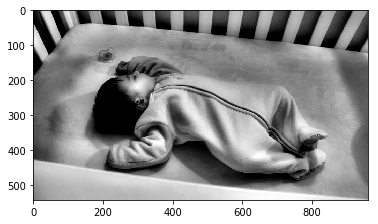

In [22]:
plt.imshow(Rec0[], cmap = 'gray')

In [ ]:
len(Rec0)

In [ ]:
Rec0[0].shape